In [ ]:
#!pip uninstall opencv-python

In [1]:
#!pip install -q -U "tensorflow-text==2.5.*"

In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
gpu = gpus[0]

tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
import pandas as pd
import numpy as np
import datetime

import tensorflow_text as text
import tensorflow_hub as hub

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score

from tensorboard.plugins.hparams import api as hp

In [233]:
#!python -m spacy download en_core_web_md -q

In [4]:
import spacy

In [5]:
from spacy.lang.en.stop_words import STOP_WORDS

In [6]:
import re

In [7]:
data = pd.read_csv('./spam.csv', encoding = 'ISO-8859-1')

In [8]:
data = data[['v1','v2']]

In [9]:
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
data['v2'][2]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

In [11]:
data['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

In [12]:
data['v2_clean'] = data['v2'].apply(lambda s : re.sub(r'[^\w\s]', '', s).lower())

In [13]:
data['v2_clean'] = data['v2_clean'].apply(lambda s : re.sub('[0-9]+', '', s))

In [14]:
data.head()

,v1,v2,v2_clean
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


In [15]:
nlp = spacy.load('en_core_web_md')

In [16]:
data["v2_lemma"] = data["v2_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

In [17]:
data.head()

,v1,v2,v2_clean,v2_lemma
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...,free entry wkly comp win fa cup final tkts s...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,nah think usf live


In [18]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=2000, oov_token="out_of_vocab")
tokenizer.fit_on_texts(data['v2_lemma'])

In [19]:
vocab_size = tokenizer.num_words

In [20]:
data["v2_tokenized"] = tokenizer.texts_to_sequences(data['v2_lemma'])

In [21]:
data.head()

,v1,v2,v2_clean,v2_lemma,v2_tokenized
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,jurong point crazy available bugis n great wor...,"[1, 225, 433, 449, 905, 35, 50, 205, 744, 79, ..."
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni,"[10, 194, 1, 283, 2, 1382]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...,free entry wkly comp win fa cup final tkts s...,"[9, 295, 519, 639, 32, 1383, 745, 411, 1384, 1..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun early hor u c,"[2, 124, 150, 1, 2, 81]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,nah think usf live,"[684, 22, 640, 125]"


In [22]:
def data_under_sampling(data, nb_reduce):
  data_sample_2 = data.loc[data['v1']=='spam',:]
  len_class_sub = len(data_sample_2)
  data_sample_1 = data.loc[data['v1']=='ham',:].sample(nb_reduce * len_class_sub)
  
  return pd.concat([data_sample_1,data_sample_2], axis=0).sample(frac=1).reset_index(drop=True)


In [23]:
data_red = data_under_sampling(data, 1)

In [24]:
v2_pad = tf.keras.preprocessing.sequence.pad_sequences(data_red['v2_tokenized'], padding="post")

In [25]:
preprocessor = LabelEncoder()

In [26]:
y = preprocessor.fit_transform(data_red['v1'])

In [27]:
x_train, x_val, y_train, y_val = train_test_split(v2_pad, y, test_size=0.2, stratify=y, random_state=2)
train_batch = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(64)
val_batch = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(64)
print('Preprocessing done --- extract of val_batch : ')
for sentence, target in val_batch.take(1):
  print(sentence, target)

Preprocessing done --- extract of val_batch : 
tf.Tensor(
[[179 431   3 ...   0   0   0]
 [961 200 568 ...   0   0   0]
 [  1 289 126 ...   0   0   0]
 ...
 [ 66  13   1 ...   0   0   0]
 [  1   1 202 ...   0   0   0]
 [346   7   1 ...   0   0   0]], shape=(64, 70), dtype=int32) tf.Tensor(
[0 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1
 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0], shape=(64,), dtype=int32)


In [28]:
AUTOTUNE = tf.data.AUTOTUNE

train_batch = train_batch.cache().prefetch(buffer_size=AUTOTUNE)
val_batch = val_batch.cache().prefetch(buffer_size=AUTOTUNE)

In [29]:
v2_pad.shape[1]

70

In [30]:
model_1 = tf.keras.Sequential([        
                  tf.keras.layers.Embedding(vocab_size+1, 128, input_shape=[v2_pad.shape[1],],name="embedding"),
                  tf.keras.layers.GlobalAveragePooling1D(),
                  tf.keras.layers.Dense(64, activation='relu'),
                  tf.keras.layers.Dropout(0.3),
                  tf.keras.layers.Dense(32, activation='relu'),
                  tf.keras.layers.Dropout(0.1),
                  tf.keras.layers.Dense(8, activation='relu'),
                  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [31]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 128)           256128    
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [32]:
optimizer= tf.keras.optimizers.Adam()

model_1.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])

In [33]:
log_dir="logs/fit/" + "simple_3_layers_rnn " + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
hparams_callback_1 = hp.KerasCallback(log_dir, {
    'dim_embeders':128,
    'nb_dense_units': 112,
    'dropout_1': 0.2,
    'dropout_2' : 0.1
})

In [34]:
model_1.fit(
    train_batch,
    epochs=20,
    verbose=1,
    callbacks=[tensorboard_callback, hparams_callback_1],
    validation_data=val_batch)

Epoch 1/20
19/19 [==============================] - 3s 55ms/step - loss: 0.6914 - accuracy: 0.5280 - precision: 0.5590 - recall: 0.2692 - val_loss: 0.6865 - val_accuracy: 0.5117 - val_precision: 1.0000 - val_recall: 0.0201
Epoch 2/20
19/19 [==============================] - 1s 26ms/step - loss: 0.6844 - accuracy: 0.6368 - precision: 0.7158 - recall: 0.4548 - val_loss: 0.6734 - val_accuracy: 0.7425 - val_precision: 0.9737 - val_recall: 0.4966
Epoch 3/20
19/19 [==============================] - 0s 25ms/step - loss: 0.6628 - accuracy: 0.7791 - precision: 0.8813 - recall: 0.6455 - val_loss: 0.6361 - val_accuracy: 0.7960 - val_precision: 0.9783 - val_recall: 0.6040
Epoch 4/20
19/19 [==============================] - 0s 24ms/step - loss: 0.6064 - accuracy: 0.8586 - precision: 0.9554 - recall: 0.7525 - val_loss: 0.5436 - val_accuracy: 0.8662 - val_precision: 0.9823 - val_recall: 0.7450
Epoch 5/20
19/19 [==============================] - 0s 25ms/step - loss: 0.4923 - accuracy: 0.8937 - precisi

In [35]:
def predictions_singleton_to_binary(model, tresh, x_val, y_val):
  y_true = y_val
  y_pred = np.where(model.predict(x_val) > tresh, 1, 0)
  return y_true, y_pred

In [36]:
def display_matrix_and_scores(y_true, y_pred):
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
  print(f'Accuracy : {accuracy_score(y_true,y_pred)}')
  print(f'Precision : {precision_score(y_true,y_pred)}')
  print(f'Recall : {recall_score(y_true,y_pred)}')

In [37]:
y_true, y_pred = predictions_singleton_to_binary(model_1, 0.5, x_val, y_val)

10/10 [==============================] - 0s 3ms/step


Accuracy : 0.959866220735786
Precision : 0.9928057553956835
Recall : 0.9261744966442953


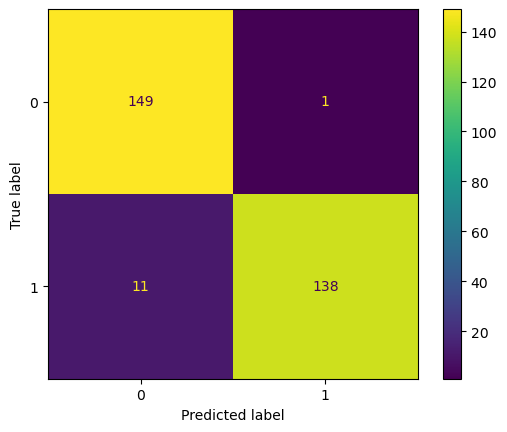

In [38]:
display_matrix_and_scores(y_true, y_pred)

In [39]:
y_true, y_pred = predictions_singleton_to_binary(model_1, 0.8, x_val, y_val)

10/10 [==============================] - 0s 3ms/step


Accuracy : 0.9531772575250836
Precision : 0.9927007299270073
Recall : 0.912751677852349


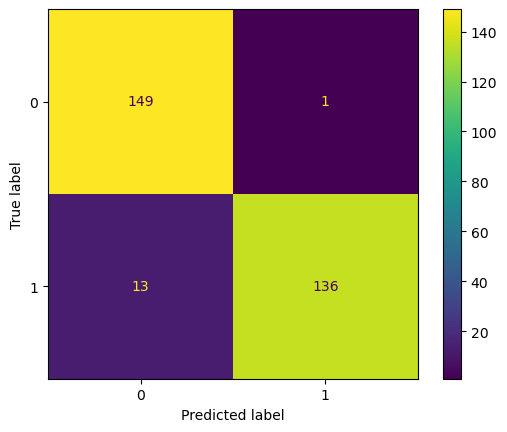

In [40]:
display_matrix_and_scores(y_true, y_pred)

In [213]:
def one_hot_encoder(series):
  label2int = {"ham": [1,0], "spam": [0,1]}
  return [label2int[label] for label in series]

In [214]:
y = one_hot_encoder(data_red['v1'])

In [215]:
y[0:5]

[[0, 1], [0, 1], [1, 0], [1, 0], [0, 1]]

In [216]:
x_train, x_val, y_train, y_val = train_test_split(v2_pad, y, test_size=0.2, stratify=y, random_state=2)

In [217]:
train_batch = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(64)
val_batch = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(64)

In [218]:
model_1_bis = tf.keras.Sequential([        
                  tf.keras.layers.Embedding(vocab_size+1, 128, input_shape=[v2_pad.shape[1],],name="embedding"),
                  tf.keras.layers.GlobalAveragePooling1D(),
                  tf.keras.layers.Dense(64, activation='relu'),
                  tf.keras.layers.Dropout(0.3),
                  tf.keras.layers.Dense(32, activation='relu'),
                  tf.keras.layers.Dropout(0.1),
                  tf.keras.layers.Dense(8, activation='relu'),
                  tf.keras.layers.Dense(2, activation="softmax")
])

In [219]:
model_1_bis.compile(optimizer="adam",
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])

In [220]:
log_dir="logs/fit/" + "simple_3_layers_rnn_with_softmax " + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
hparams_callback_1_bis = hp.KerasCallback(log_dir, {
    'dim_embeders':128,
    'nb_dense_units': 112,
    'dropout_1': 0.2,
    'dropout_2' : 0.1
})

In [221]:
model_1_bis.fit(
    train_batch,
    epochs=20,
    verbose=1,
    callbacks=[tensorboard_callback, hparams_callback_1_bis],
    validation_data=val_batch)

Epoch 1/20
19/19 [==============================] - 6s 220ms/step - loss: 0.6926 - accuracy: 0.5264 - precision: 0.5264 - recall: 0.5264 - val_loss: 0.6893 - val_accuracy: 0.4950 - val_precision: 0.4950 - val_recall: 0.4950
Epoch 2/20
19/19 [==============================] - 1s 27ms/step - loss: 0.6860 - accuracy: 0.6100 - precision: 0.6100 - recall: 0.6100 - val_loss: 0.6776 - val_accuracy: 0.5920 - val_precision: 0.5920 - val_recall: 0.5920
Epoch 3/20
19/19 [==============================] - 1s 40ms/step - loss: 0.6657 - accuracy: 0.7649 - precision: 0.7649 - recall: 0.7649 - val_loss: 0.6421 - val_accuracy: 0.8227 - val_precision: 0.8227 - val_recall: 0.8227
Epoch 4/20
19/19 [==============================] - 1s 30ms/step - loss: 0.6068 - accuracy: 0.8577 - precision: 0.8577 - recall: 0.8577 - val_loss: 0.5422 - val_accuracy: 0.9030 - val_precision: 0.9030 - val_recall: 0.9030
Epoch 5/20
19/19 [==============================] - 1s 28ms/step - loss: 0.4638 - accuracy: 0.9130 - precis

In [222]:
model_1_bis.predict(x_val)[0:5]

array([[9.9046457e-01, 9.5354021e-03],
       [9.9669975e-01, 3.3002838e-03],
       [9.9610645e-01, 3.8934941e-03],
       [1.9252853e-05, 9.9998069e-01],
       [2.0218322e-04, 9.9979788e-01]], dtype=float32)

In [223]:
def predictions_tupple_to_binary(model, tresh_suppl, x_val, y_val):
  y_true = []
  y_pred = []
  tupple_predictions = model.predict(x_val)
  for i in range(len(x_val)):
    y_true.append(0 if y_val[i][0]==1 else 1)
    y_pred.append(0 if tupple_predictions[i][0] + tresh_suppl > tupple_predictions[i][1] else 1)
  return y_true, y_pred

In [224]:
y_true, y_pred = predictions_tupple_to_binary(model_1_bis, 0, x_val, y_val)

Accuracy : 0.9565217391304348
Precision : 0.9724137931034482
Recall : 0.94


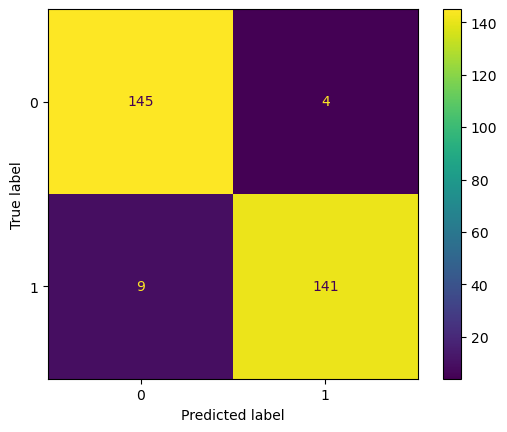

In [225]:
display_matrix_and_scores(y_true, y_pred)

In [226]:
y_true, y_pred = predictions_tupple_to_binary(model_1_bis, 0.635, x_val, y_val)

Accuracy : 0.9565217391304348
Precision : 0.9858156028368794
Recall : 0.9266666666666666


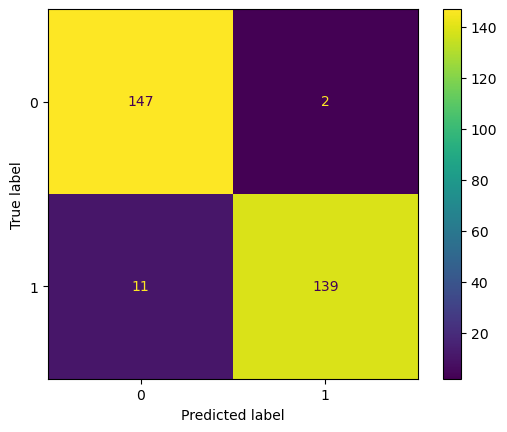

In [227]:
display_matrix_and_scores(y_true, y_pred)

In [46]:
y = preprocessor.fit_transform(data_red['v1'])

In [47]:
x_train, x_val, y_train, y_val = train_test_split(v2_pad, y, test_size=0.2, stratify=y, random_state=2)
train_batch = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(64)
val_batch = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(64)

In [48]:
AUTOTUNE = tf.data.AUTOTUNE

train_batch = train_batch.cache().prefetch(buffer_size=AUTOTUNE)
val_batch = val_batch.cache().prefetch(buffer_size=AUTOTUNE)

In [58]:
model_2 = tf.keras.Sequential([        
                  tf.keras.layers.Embedding(vocab_size+1, 128, input_shape=[v2_pad.shape[1],],name="embedding"),
                  tf.keras.layers.SimpleRNN(units=64, return_sequences=True),
                  tf.keras.layers.SimpleRNN(units=32, return_sequences=False),
                  tf.keras.layers.Dense(8, activation='relu'),
                  tf.keras.layers.Dropout(0.1),
                  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [59]:
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 128)           256128    
                                                                 
 simple_rnn (SimpleRNN)      (None, 70, 64)            12352     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_10 (Dense)            (None, 8)                 264       
                                                                 
 dropout_5 (Dropout)         (None, 8)                 0         
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 271,857
Trainable params: 271,857
Non-tr

In [60]:
model_2.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])

In [61]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
hparams_callback_2 = hp.KerasCallback(log_dir, {
    'num_dense_units': 8,
    'num_rnn_units':96,
    'dropout_2': 0.1
})

In [62]:
model_2.fit(
    train_batch,
    epochs=20,
    verbose=1,
    callbacks=[tensorboard_callback, hparams_callback_2],
    validation_data=val_batch)

Epoch 1/20
19/19 [==============================] - 15s 623ms/step - loss: 0.5129 - accuracy: 0.7816 - precision: 0.8138 - recall: 0.7308 - val_loss: 0.3596 - val_accuracy: 0.8696 - val_precision: 0.9365 - val_recall: 0.7919
Epoch 2/20
19/19 [==============================] - 11s 578ms/step - loss: 0.2523 - accuracy: 0.9297 - precision: 0.9690 - recall: 0.8880 - val_loss: 0.2790 - val_accuracy: 0.9030 - val_precision: 0.9348 - val_recall: 0.8658
Epoch 3/20
19/19 [==============================] - 11s 585ms/step - loss: 0.2195 - accuracy: 0.9397 - precision: 0.9598 - recall: 0.9181 - val_loss: 0.3676 - val_accuracy: 0.8796 - val_precision: 0.9124 - val_recall: 0.8389
Epoch 4/20
19/19 [==============================] - 11s 586ms/step - loss: 0.1317 - accuracy: 0.9690 - precision: 0.9779 - recall: 0.9599 - val_loss: 0.2664 - val_accuracy: 0.9130 - val_precision: 0.9241 - val_recall: 0.8993
Epoch 5/20
19/19 [==============================] - 12s 608ms/step - loss: 0.0834 - accuracy: 0.9816

In [54]:
y_true, y_pred = predictions_singleton_to_binary(model_2, 0.5, x_val, y_val)

10/10 [==============================] - 1s 36ms/step


Accuracy : 0.8795986622073578
Precision : 0.8843537414965986
Recall : 0.87248322147651


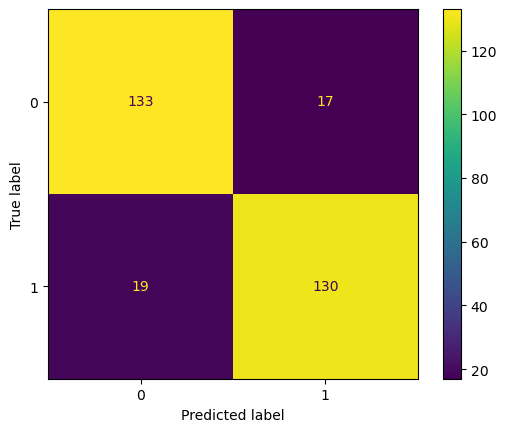

In [55]:
display_matrix_and_scores(y_true, y_pred)

In [56]:
model_3 = tf.keras.Sequential([        
                  tf.keras.layers.Embedding(vocab_size+1, 128, input_shape=[v2_pad.shape[1],],name="embedding"),
                  tf.keras.layers.SimpleRNN(units=64, return_sequences=True),
                  tf.keras.layers.Dropout(0.2),
                  tf.keras.layers.SimpleRNN(units=32, return_sequences=True),
                  tf.keras.layers.Dropout(0.2),
                  tf.keras.layers.SimpleRNN(units=16, return_sequences=True),
                  tf.keras.layers.GlobalAveragePooling1D(),
                  tf.keras.layers.Dropout(0.2),
                  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [57]:
model_3.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])

In [58]:
log_dir="logs/fit/" + "model_3_3_RNN_with_global_pooling " + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
hparams_callback_3 = hp.KerasCallback(log_dir, {
    'num_dense_units': 8,
    'num_rnn_units':96,
    'dropout_2': 0.5
})

In [59]:
model_3.fit(
    train_batch,
    epochs=20,
    verbose=1,
    callbacks=[tensorboard_callback, hparams_callback_3],
    validation_data=val_batch)

Epoch 1/20
19/19 [==============================] - 21s 822ms/step - loss: 0.5529 - accuracy: 0.7230 - precision: 0.7063 - recall: 0.7642 - val_loss: 0.2679 - val_accuracy: 0.9365 - val_precision: 0.9851 - val_recall: 0.8859
Epoch 2/20
19/19 [==============================] - 14s 735ms/step - loss: 0.2281 - accuracy: 0.9423 - precision: 0.9460 - recall: 0.9381 - val_loss: 0.1740 - val_accuracy: 0.9532 - val_precision: 0.9787 - val_recall: 0.9262
Epoch 3/20
19/19 [==============================] - 13s 710ms/step - loss: 0.2077 - accuracy: 0.9464 - precision: 0.9238 - recall: 0.9732 - val_loss: 0.1927 - val_accuracy: 0.9431 - val_precision: 0.9853 - val_recall: 0.8993
Epoch 4/20
19/19 [==============================] - 14s 739ms/step - loss: 0.1365 - accuracy: 0.9699 - precision: 0.9763 - recall: 0.9632 - val_loss: 0.2938 - val_accuracy: 0.9197 - val_precision: 0.9139 - val_recall: 0.9262
Epoch 5/20
19/19 [==============================] - 13s 689ms/step - loss: 0.1411 - accuracy: 0.9682

In [60]:
y_true, y_pred = predictions_singleton_to_binary(model_3, 0.5, x_val, y_val)

10/10 [==============================] - 1s 53ms/step


Accuracy : 0.9230769230769231
Precision : 0.9772727272727273
Recall : 0.8657718120805369


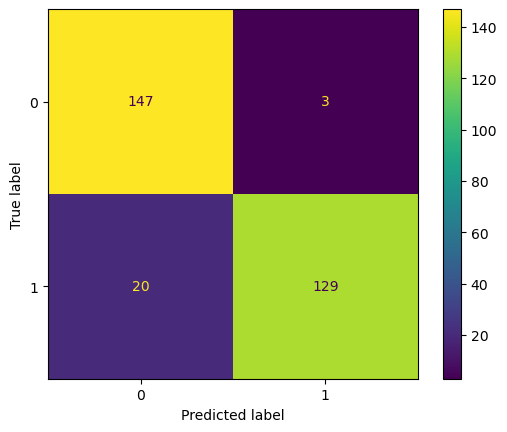

In [61]:
display_matrix_and_scores(y_true, y_pred)

In [75]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_base/3")

In [59]:
y = preprocessor.fit_transform(data_red['v1'])

In [60]:
x_train, x_val, y_train, y_val = train_test_split(data_red['v2'], y, test_size=0.2, stratify=y)

In [61]:
train_batch = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(64)
val_batch = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(64)

In [62]:
AUTOTUNE = tf.data.AUTOTUNE

train_batch = train_batch.cache().prefetch(buffer_size=AUTOTUNE)
val_batch = val_batch.cache().prefetch(buffer_size=AUTOTUNE)

In [63]:
for sent, targ in train_batch.take(1):
  print(sent)
  print(targ)

tf.Tensor(
[b'So can collect ur laptop?'
 b"No i'm not gonna be able to. || too late notice. || i'll be home in a few weeks anyway. || what are the plans"
 b'Your account has been credited with 500 FREE Text Messages. To activate, just txt the word: CREDIT to No: 80488 T&Cs www.80488.biz'
 b'Ur cash-balance is currently 500 pounds - to maximize ur cash-in now send GO to 86688 only 150p/msg. CC: 08718720201 PO BOX 114/14 TCR/W1'
 b'Talk With Yourself Atleast Once In A Day...!!! Otherwise You Will Miss Your Best FRIEND In This WORLD...!!! -Shakespeare- SHESIL  &lt;#&gt;'
 b'Going on nothing great.bye' b'Studying. But i.ll be free next weekend.'
 b"Nvm it's ok..."
 b'Fantasy Football is back on your TV. Go to Sky Gamestar on Sky Active and play \xc3\xa5\xc2\xa3250k Dream Team. Scoring starts on Saturday, so register now!SKY OPT OUT to 88088'
 b'Was actually sleeping and still might when u call back. So a text is gr8. You rock sis. Will send u a text wen i wake.'
 b'You have WON a guarante

In [90]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
l = tf.keras.layers.Dropout(0.2, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
model_4 = tf.keras.Model(inputs=[text_input], outputs = [l])

In [91]:
model_4.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [92]:
model_4.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])

In [93]:
log_dir="logs/fit/" + 'model_4_bert ' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
hparams_callback_4 = hp.KerasCallback(log_dir, {
    'bert': 1,
    'dropout_1': 0.1
})

In [94]:
model_4.fit(
    train_batch,
    epochs=30,
    verbose=1,
    validation_data=val_batch)

Epoch 1/30
19/19 [==============================] - 75s 4s/step - loss: 0.7464 - accuracy: 0.5138 - precision: 0.5141 - recall: 0.5167 - val_loss: 0.6217 - val_accuracy: 0.6890 - val_precision: 0.7642 - val_recall: 0.5436
Epoch 2/30
19/19 [==============================] - 68s 4s/step - loss: 0.5662 - accuracy: 0.7130 - precision: 0.7165 - recall: 0.7057 - val_loss: 0.4963 - val_accuracy: 0.8428 - val_precision: 0.8542 - val_recall: 0.8255
Epoch 3/30
19/19 [==============================] - 68s 4s/step - loss: 0.4521 - accuracy: 0.8301 - precision: 0.8222 - recall: 0.8428 - val_loss: 0.4285 - val_accuracy: 0.8495 - val_precision: 0.8611 - val_recall: 0.8322
Epoch 4/30
19/19 [==============================] - 68s 4s/step - loss: 0.3864 - accuracy: 0.8628 - precision: 0.8690 - recall: 0.8545 - val_loss: 0.3836 - val_accuracy: 0.8629 - val_precision: 0.8600 - val_recall: 0.8658
Epoch 5/30
19/19 [==============================] - 68s 4s/step - loss: 0.3533 - accuracy: 0.8678 - precision: 0

In [95]:
y_true, y_pred = predictions_singleton_to_binary(model_4, 0.5, x_val, y_val)

10/10 [==============================] - 13s 1s/step


Accuracy : 0.9565217391304348
Precision : 0.9722222222222222
Recall : 0.9395973154362416


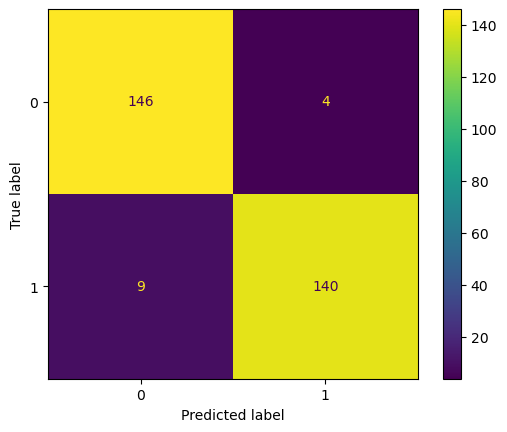

In [96]:
display_matrix_and_scores(y_true, y_pred)